# OV fiets analysis

In [1]:
import pandas as pd
import numpy as np
from tabula import read_pdf
import jenkspy
# pd.set_option('precision', 3)

## Reading and cleaning data

In [154]:
# new train passenger numbers

pax_df_raw= pd.read_csv("train_passengers_2019.csv")

In [155]:
pax_df_raw.columns

Index(['Alias', 'Name', 'UrlPart', 'Coordinate', 'Type', 'Size', 'Data', '0',
       'TravelersPerDay', 'BoardingDeboarding', 'Transfering', 'PreWalking',
       'PreBicycle', 'PreCarDriver', 'PreCarPassenger', 'PreBTM', 'PreTaxi',
       'PostWalking', 'PostBicycle', 'PostCarDriver', 'PostCarPassenger',
       'PostBTM', 'PostTaxi', 'MorningRush', 'EveningRush', 'LowTime',
       'Percentage7Plus'],
      dtype='object')

In [156]:
pax_df = (
    pax_df_raw
    .loc[~pax_df_raw['BoardingDeboarding'].isna()]
    .assign(daily_pax = lambda x: x.Transfering + x.BoardingDeboarding)
    .rename(columns={'Name':'station'})
    .drop(['0','Data','TravelersPerDay'],axis=1)
)
pax_df.sample(3)

,Alias,station,UrlPart,Coordinate,Type,Size,BoardingDeboarding,Transfering,PreWalking,PreBicycle,...,PostBicycle,PostCarDriver,PostCarPassenger,PostBTM,PostTaxi,MorningRush,EveningRush,LowTime,Percentage7Plus,daily_pax
62,BKF,Bovenkarspel Flora,bovenkarspel-flora,"{'Lat': 52.6960292189898, 'Lng': 5.25326997902...",ns,halte,720.0,0.0,48.256944,37.418090,...,40.931522,1.142296,15.708229,3.623413,0.0,36.010363,8.549223,55.440415,NaN,720.0
74,BNK,Bunnik,bunnik,"{'Lat': 52.0633000003113, 'Lng': 5.19570000047...",ns,basis,2428.0,0.0,30.651149,43.472921,...,36.650906,1.281746,7.848601,3.565099,0.0,21.933086,28.903346,49.163569,0.712500,2428.0
99,GVY,Den Haag Ypenburg,den-haag-ypenburg,NaN,ns,basis,2526.0,0.0,18.957187,45.164634,...,18.359173,1.160941,13.424317,29.401653,0.0,33.873874,16.846847,49.279279,0.567416,2526.0


In [176]:
# pax_df.loc[(pax_df['daily_pax']<20000),'typology'] = '0-20,000'
# pax_df.loc[(pax_df['daily_pax']>=20000)&(daily_pax['pop']<50000),'typology'] = '20,000-50,000'
# pax_df.loc[(pax_df['daily_pax']>=50000)&(daily_pax['pop']<100000),'typology'] = '50,000-100,000'
# pax_df.loc[(pax_df['daily_pax']>=100000)&(daily_pax['pop']<200000),'typology'] = '100,000-200,000'
# pax_df.loc[(pax_df['daily_pax']>=200000)&(daily_pax['pop']<500000),'typology'] = '200,000-500,000'
# pax_df.loc[(pax_df['daily_pax']>=500000),'typology'] = '500,000+'

# pax_df.head(10)

In [199]:
ov_fiets_file = 'ovfiets 16 May 2022 - ovfiets.csv'
bikes_df = pd.read_csv(ov_fiets_file)

bikes_df = (
    bikes_df
    .drop(['URL','Lat','Lng','Bikes available','Extra bikes'],axis=1)
    .rename(columns={'Location':'station','Total bikes available':'bikes','Station name':'station_name'})
    .assign(
        bikes=lambda x: x.bikes.str.extract('(\d+)').astype(float),
        station = lambda x: np.where(x.station_name == 'None', 
                                     x.station, 
                                     x.station_name.str.replace('Station ',''))
    )
    .groupby('station').sum()
    .query("bikes > 0")
    .query("station != 'Schiphol Airport'") # outlier (lots of passengers but 0 bikes)
    .reset_index()
)
bikes_df

,station,bikes
0,'s-Hertogenbosch,225.0
1,'s-Hertogenbosch Oost,8.0
2,'t Harde,8.0
3,Aalten,6.0
4,Alkmaar,162.0
...,...,...
254,Zoetermeer Oost,4.0
255,Zuidhorn,8.0
256,Zutphen,126.0
257,Zwijndrecht,32.0


## Merging

In [200]:
# merging ....

print('Match: ',len(bikes_df) - bikes_df.merge(pax_df, how='left')['daily_pax'].isna().sum(),'out of',len(bikes_df))

Match:  181 out of 259


In [201]:
bikes_df.merge(pax_df, how='left')[['station','daily_pax']]

,station,daily_pax
0,'s-Hertogenbosch,67022.0
1,'s-Hertogenbosch Oost,NaN
2,'t Harde,NaN
3,Aalten,NaN
4,Alkmaar,21548.0
...,...,...
254,Zoetermeer Oost,3177.0
255,Zuidhorn,NaN
256,Zutphen,12253.0
257,Zwijndrecht,5427.0


In [202]:
from fuzzywuzzy import process

def fuzzy_merge(df, df2, on=None, left_on=None, right_on=None, how='inner', threshold=80):
    
    def fuzzy_apply(x, df, column, threshold=threshold):
        if type(x)!=str:
            return None
        
        match, score, *_ = process.extractOne(x, df[column])
            
        if score >= threshold:
            return match

        else:
            return None
    
    if on is not None:
        left_on = on
        right_on = on

    # create temp column as the best fuzzy match (or None!)
    df2['tmp'] = df2[right_on].apply(
        fuzzy_apply, 
        df=df, 
        column=left_on, 
        threshold=threshold
    )

    merged_df = df.merge(df2, how=how, left_on=left_on, right_on='tmp')
    
    del merged_df['tmp']
    
    return merged_df

In [203]:
fuzzy_merge_df = fuzzy_merge(bikes_df, pax_df, on='station', how='left', threshold=95)

In [204]:
# fuzzy_merge_df.sort_values('bikes', ascending=False).query("Type.isna()")

## Analysis

In [205]:
fuzzy_merge_df.isna().sum()

station_x              0
bikes                  0
Alias                 75
station_y             75
UrlPart               75
Coordinate            77
Type                  75
Size                  75
BoardingDeboarding    75
Transfering           75
PreWalking            77
PreBicycle            77
PreCarDriver          77
PreCarPassenger       77
PreBTM                77
PreTaxi               77
PostWalking           77
PostBicycle           77
PostCarDriver         77
PostCarPassenger      77
PostBTM               77
PostTaxi              77
MorningRush           76
EveningRush           76
LowTime               76
Percentage7Plus       83
daily_pax             75
dtype: int64

In [206]:
df = fuzzy_merge_df.dropna(subset='daily_pax')

In [207]:
df.corr()

,bikes,BoardingDeboarding,Transfering,PreWalking,PreBicycle,PreCarDriver,PreCarPassenger,PreBTM,PreTaxi,PostWalking,PostBicycle,PostCarDriver,PostCarPassenger,PostBTM,PostTaxi,MorningRush,EveningRush,LowTime,Percentage7Plus,daily_pax
bikes,1.000000,0.908570,0.740278,-0.206678,0.069062,-0.349962,-0.247917,0.448442,0.061665,-0.143564,-0.037114,0.127272,-0.293929,0.452774,-0.090727,-0.416156,0.349796,0.337041,0.357915,0.902795
BoardingDeboarding,0.908570,1.000000,0.817205,-0.202626,0.005287,-0.379445,-0.293448,0.533275,-0.004948,-0.112884,-0.114974,0.110782,-0.328876,0.489508,-0.123383,-0.427563,0.374781,0.323236,0.303219,0.994102
Transfering,0.740278,0.817205,1.000000,-0.140268,0.052784,-0.262279,-0.210856,0.329847,-0.000162,-0.039060,-0.073509,0.113552,-0.219602,0.275186,-0.072822,-0.284759,0.282239,0.166438,0.265990,0.874891
PreWalking,-0.206678,-0.202626,-0.140268,1.000000,-0.273457,-0.276667,-0.562224,-0.392481,-0.193441,0.669767,-0.155197,-0.031734,-0.426612,-0.357695,-0.150973,-0.071850,0.038773,0.091401,-0.110359,-0.196667
PreBicycle,0.069062,0.005287,0.052784,-0.273457,1.000000,-0.207029,-0.100422,-0.407067,-0.082057,-0.025813,0.464448,-0.190132,0.091417,-0.268797,0.035098,0.298080,-0.237579,-0.264767,0.272833,0.014378
PreCarDriver,-0.349962,-0.379445,-0.262279,-0.276667,-0.207029,1.000000,0.590909,-0.386831,0.058370,-0.286690,0.057168,0.085333,0.716866,-0.337566,0.195195,0.451931,-0.366332,-0.392284,-0.157702,-0.368212
PreCarPassenger,-0.247917,-0.293448,-0.210856,-0.562224,-0.100422,0.590909,1.000000,-0.070001,0.400576,-0.503032,0.135063,0.087120,0.691806,-0.093527,0.327002,0.302964,-0.360104,-0.092174,-0.054919,-0.286270
PreBTM,0.448442,0.533275,0.329847,-0.392481,-0.407067,-0.386831,-0.070001,1.000000,0.071872,-0.288790,-0.318275,0.105755,-0.342742,0.824674,-0.114749,-0.566731,0.513835,0.410728,-0.012725,0.510192
PreTaxi,0.061665,-0.004948,-0.000162,-0.193441,-0.082057,0.058370,0.400576,0.071872,1.000000,-0.182083,-0.025961,0.139946,0.151346,0.078718,0.170328,-0.077606,-0.033554,0.211227,0.062321,-0.004188
PostWalking,-0.143564,-0.112884,-0.039060,0.669767,-0.025813,-0.286690,-0.503032,-0.288790,-0.182083,1.000000,-0.362619,-0.156353,-0.563816,-0.521357,-0.217455,-0.189463,0.201522,0.092951,-0.043272,-0.102207


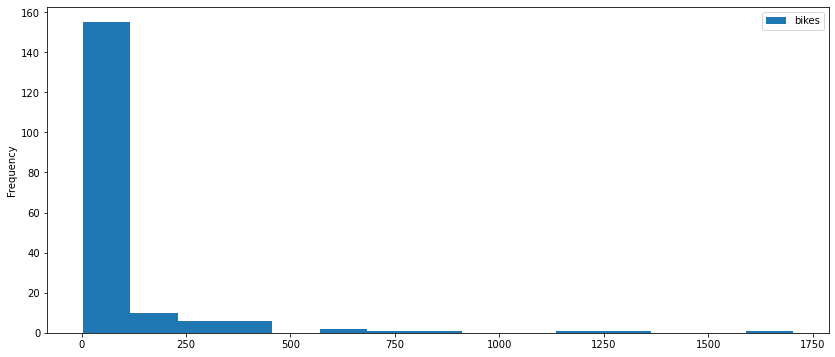

In [208]:
df.plot.hist(y='bikes',bins=15,figsize=(14, 6));

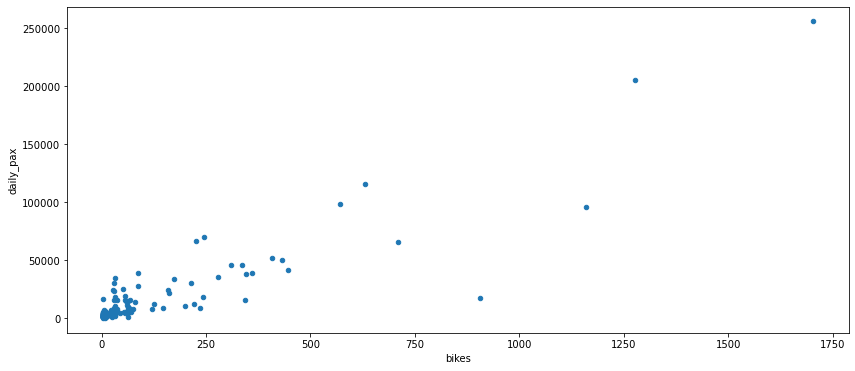

In [352]:
plot = df.plot.scatter(y='daily_pax', x='bikes',figsize=(14, 6));
fig = plot.get_figure()
fig.savefig('scatter_plot.png',bbox_inches='tight', facecolor='white')

In [228]:
df.query("bikes > 800 and daily_pax < 20_000")

,station_x,bikes,Alias,station_y,UrlPart,Coordinate,Type,Size,BoardingDeboarding,Transfering,...,PostBicycle,PostCarDriver,PostCarPassenger,PostBTM,PostTaxi,MorningRush,EveningRush,LowTime,Percentage7Plus,daily_pax
95,Groningen,905.0,GN,Groningen,groningen,"{'Lat': 53.2108999998704, 'Lng': 6.56370000010...",ns-other,mega,17768.0,85.0,...,18.31228,2.793347,9.942643,33.715041,0.894007,13.187358,18.329535,68.483107,0.887395,17853.0


In [229]:
df.query("bikes < 100 and daily_pax > 100_000")

,station_x,bikes,Alias,station_y,UrlPart,Coordinate,Type,Size,BoardingDeboarding,Transfering,...,PostBicycle,PostCarDriver,PostCarPassenger,PostBTM,PostTaxi,MorningRush,EveningRush,LowTime,Percentage7Plus,daily_pax


In [230]:
df.bikes.describe()

count     184.000000
mean       87.130435
std       213.705646
min         3.000000
25%         6.000000
50%        25.000000
75%        55.000000
max      1703.000000
Name: bikes, dtype: float64

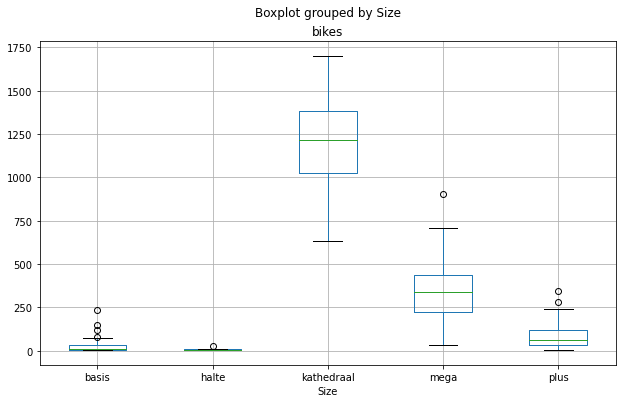

In [231]:
df.boxplot(column='bikes',by='Size', figsize=(10, 6));

In [232]:
df.groupby("Size",).agg(['min','mean','median','max','count'],)[['daily_pax','bikes']].sort_values(('daily_pax','mean'))

C:\Users\FrancescoCusimano\AppData\Local\Temp\ipykernel_29492\3369845501.py:1: FutureWarning: ['station_x', 'Alias', 'station_y', 'UrlPart', 'Coordinate', 'Type'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby("Size",).agg(['min','mean','median','max','count'],)[['daily_pax','bikes']].sort_values(('daily_pax','mean'))


daily_pax                                           bikes  \
                 min           mean    median       max count    min   
Size                                                                   
halte          785.0    1397.692308    1382.0    2664.0    13    4.0   
basis          338.0    4024.033058    3424.0   14406.0   121    3.0   
plus          4864.0   16993.500000   15560.0   35294.0    30    4.0   
mega         17853.0   47452.125000   43986.5   98661.0    16   32.0   
kathedraal   95881.0  168093.250000  160364.0  255764.0     4  631.0   

                                               
                   mean  median     max count  
Size                                           
halte          7.076923     6.0    25.0    13  
basis         21.685950     8.0   236.0   121  
plus          92.000000    59.0   343.0    30  
mega         361.625000   341.0   905.0    16  
kathedraal  1192.500000  1218.0  1703.0     4

In [233]:
df.daily_pax.describe()

count       184.000000
mean      13296.141304
std       28907.806684
min         338.000000
25%        2231.000000
50%        4666.500000
75%        9803.500000
max      255764.000000
Name: daily_pax, dtype: float64

In [234]:
from sklearn.linear_model import LinearRegression

In [235]:
lm = LinearRegression()
lm.fit(X= df[['daily_pax']],y = df.bikes)

LinearRegression()

In [236]:
print(f"for every 1 000 additional travelers, you need an extra {round((lm.coef_*1_000)[0],1)} bikes ")

for every 1 000 additional travelers, you need an extra 6.7 bikes 


In [245]:
departments = pd.read_csv(r'C:\Users\FrancescoCusimano\Documents\python_zoov_data\TER_project\departement2021.csv',sep=',')
regions = pd.read_csv(r'C:\Users\FrancescoCusimano\Documents\python_zoov_data\TER_project\region2021.csv',sep=',')
departments = departments[~departments['LIBELLE'].isin(['Corse-du-Sud','Haute-Corse'])]
REG_codes = regions.REG.tolist()
DEP_codes = departments[departments['REG'].isin(REG_codes)].DEP.astype(int).tolist()
departments_merged = departments.merge(regions,on='REG')
departments_merged = departments_merged[~departments_merged['LIBELLE_x'].isin(['Corse-du-Sud','Haute-Corse'])]
departments_merged['DEP'] = pd.to_numeric(departments_merged['DEP'])
departments_merged = departments_merged.rename(columns={'LIBELLE_x':'DEP_name','LIBELLE_y':'REG_name'})

In [347]:
sncf_pax = pd.read_csv(r"G:\My Drive\data-urban-planning\data\in\FR\SNCF\frequentation-gares.csv", sep=';')
sncf_pax = (
    sncf_pax
    .loc[:,['Nom de la gare','Total Voyageurs 2019','Code postal']]
    .rename(columns={'Nom de la gare':'station',
                     # 'Code UIC complet':'id',
                     'Code postal':'post_code',
                     'Total Voyageurs 2019':'pax_2019'
                    })
    .assign(
        # station_id = lambda x: (x.id - 87000000).astype(str),
        daily_pax = lambda x: round(x.pax_2019/365).astype(int),
        pred_bikes= lambda x: np.round(np.clip(lm.predict(x[['daily_pax']]), a_min=0, a_max=None)).astype(int),
        DEP=lambda df_:df_.post_code.astype(str).str[:2].astype(int),
    )
    .merge(departments_merged[['DEP','REG_name']])
    .loc[:,['station','pax_2019','daily_pax','pred_bikes','post_code','DEP','REG_name']]
)
sncf_pax

,station,pax_2019,daily_pax,pred_bikes,post_code,DEP,REG_name
0,Achères Grand Cormier,221003,605,2,78100,78,Île-de-France
1,Bougival,876847,2402,14,78170,78,Île-de-France
2,Coignières,466909,1279,7,78310,78,Île-de-France
3,La Celle-Saint-Cloud,2090228,5727,37,78170,78,Île-de-France
4,Limay,671707,1840,11,78520,78,Île-de-France
...,...,...,...,...,...,...,...
3003,Golfech,0,0,0,82400,82,Occitanie
3004,Lavilledieu,11468,31,0,82290,82,Occitanie
3005,Liart,274,1,0,8290,82,Occitanie
3006,Montbartier,54779,150,0,82700,82,Occitanie


In [348]:
df.bikes.describe()

count     184.000000
mean       87.130435
std       213.705646
min         3.000000
25%         6.000000
50%        25.000000
75%        55.000000
max      1703.000000
Name: bikes, dtype: float64

In [349]:
sncf_pax.pred_bikes.describe()

count    3008.000000
mean       15.894282
std       111.851784
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max      4477.000000
Name: pred_bikes, dtype: float64

In [350]:
sncf_pax.to_excel('SNCF_stations_dutch_bike_fleet.xlsx',index=False)

In [325]:
import statsmodels.api as sm
X = sm.add_constant(df['daily_pax']) # adding a constant
Y = df['bikes']

In [338]:
results = sm.OLS(endog=Y, exog=X).fit()

In [339]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  bikes   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     802.0
Date:                Tue, 07 Jun 2022   Prob (F-statistic):           1.32e-68
Time:                        15:57:30   Log-Likelihood:                -1092.4
No. Observations:                 184   AIC:                             2189.
Df Residuals:                     182   BIC:                             2195.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6087      7.482     -0.215      0.8